In [1]:
%load_ext autoreload
%autoreload 2

In [330]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from glob import glob
from scipy.signal import find_peaks
from functools import partial
from lmfit.models import GaussianModel # type: ignore

from RaTag.scripts.wfm2read_fast import wfm2read # type: ignore
from RaTag.scripts.wfm_sca_trigger import moving_average # type: ignore
from RaTag.scripts.analyse_field_scans import * # type: ignore
import RaTag.transport as trans # type: ignore

# Recommended rcParams for larger font sizes
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 18


# Identifying X-ray events

Should have a clear S2 preceding the recoil S2

In [7]:
base_dir = '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec'
voltage_pairs = extract_voltage_pairs(base_dir, pattern='FieldScan_1GSsec_EL{}_Gate{}')
anode_voltages = voltage_pairs[:,0]
gate_voltages = voltage_pairs[:,1]
field_el = (anode_voltages - gate_voltages) / 0.8  # V/cm
field_drift = gate_voltages / 1.4  # V/cm
red_field_drift = [trans.compute_reduced_field(fd) for fd in field_drift]
drift_speed = [trans.redfield_to_speed(fd) for fd in red_field_drift]  # μs/mm
drift_times = [14 / ds for ds in drift_speed]  # μs
drift_times

[np.float64(20.04565320192623),
 np.float64(15.165741857558416),
 np.float64(13.222858666166434),
 np.float64(10.920882948237741),
 np.float64(9.453403800488124),
 np.float64(8.595805442862803),
 np.float64(8.033301862437394)]

In [8]:
subdirs = sorted(glob(base_dir+'/FieldScan*'))
files05 = sorted(glob(base_dir+'/FieldScan_5GSsec_Anode1950V_Gate50V/*.wfm'))
files05[:10], subdirs[2]

(['/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V/RUN5_26052025_Gate50_Anode1950_P7_10000Wfm.wfm',
  '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V/RUN5_26052025_Gate50_Anode1950_P7_1000Wfm.wfm',
  '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V/RUN5_26052025_Gate50_Anode1950_P7_1001Wfm.wfm',
  '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V/RUN5_26052025_Gate50_Anode1950_P7_1002Wfm.wfm',
  '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V/RUN5_26052025_Gate50_Anode1950_P7_1003Wfm.wfm',
  '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V/RUN5_26052025_Gate50_Anode1950_P7_1004Wfm.wfm',
  '

In [ ]:
i = 1
xray = 0
xray_candidate = 95
xray_candidate = 310

In [55]:
i = xray_candidate

In [ ]:
Vdrift[Vdrift > 5e-4].sum() * 200

np.float64(6892.559241011738)

In [54]:
50 / len(t)

0.0002

In [21]:
s2_start = 15
s2_end = 35
t_s1 = -3.4
s1_idx = np.where(t >= t_s1)[0][0]
s2_start_idx = np.where(t >= s2_start)[0][0]
params = {'MAXabs_thesh': 1.26e-3,
          'RMS_thresh': 1.29e-3,
          'width_thresh_us': 7.5}

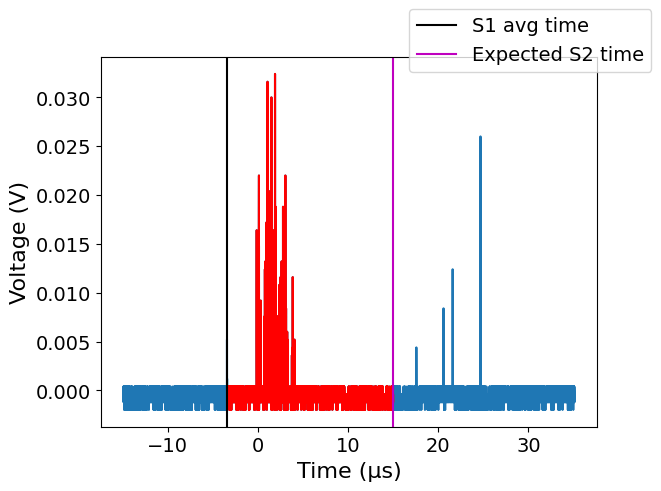

In [226]:
s1_jitter = 0.05 # μs
s2_tol_start = 2.5 # μs
s2_duration = 18 # μs
s2_tol_end = 2.5 # μs

# s2_tol_end = 10e-6
# drift_window = (t_s1 + s1_jitter, t_s1 - s1_jitter + drift_times[0] - s2_tol_start)
# s2_window = (drift_window[1], drift_window[1] + s2_duration + s2_tol_end)

drift_window = (t_s1, s2_start)
s2_window = (s2_start, s2_end)

i += 1
file = files05[i]
t, V = load_waveform(file)
t *= 1e6  # to μs

Vdrift = V[(t > drift_window[0]) & (t < drift_window[1])]
tdrift = t[(t > drift_window[0]) & (t < drift_window[1])]
plt.plot(t, V)
thresh = Vdrift > 0.02
clean_drift = len(thresh[thresh > 0]) < 3

if clean_drift:
    plt.plot(tdrift, Vdrift, 'g')
else:
    plt.plot(tdrift, Vdrift, 'r')



plt.gca().set(xlabel='Time (μs)', ylabel='Voltage (V)')
plt.axvline(drift_window[0] ,color='k', label='S1 avg time')
plt.axvline(drift_window[1], color='m', label='Expected S2 time')
# plt.axvline(s2_window[1], color='r', label='Expected S2 end time')
# plt.axvline(8, color='g', linestyle='--', label='X-ray end')
# plt.axvline(17, color='g', linestyle='--', label='actual S2 time')

plt.gcf().legend()


Ok


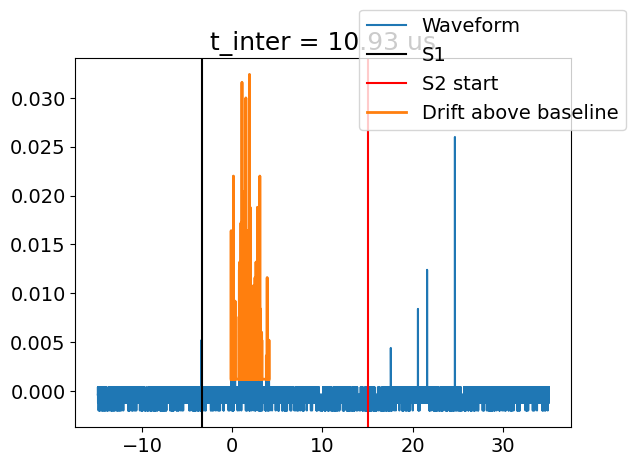

In [234]:
ok, reason = cuts.classify_event_v2(V, t, t_s1, s2_start,
                                     bs_threshold=5e-4,
                                     min_t_inter = 3,
                                      flag_plot=True)

In [265]:
t_s1 = -3400  # ns
s2_start = 15000  # ns

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Event 95, area = 7078.1 mV·ns


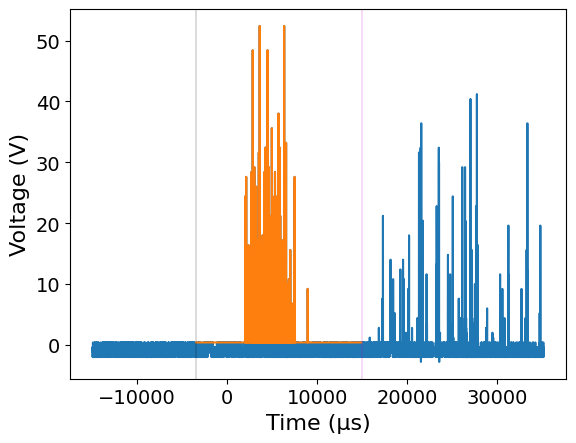

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in d

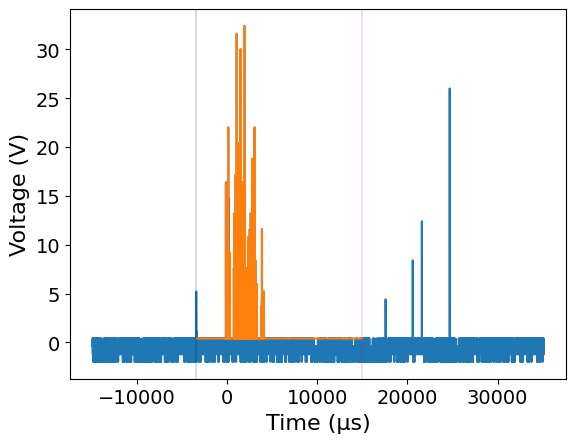

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in d

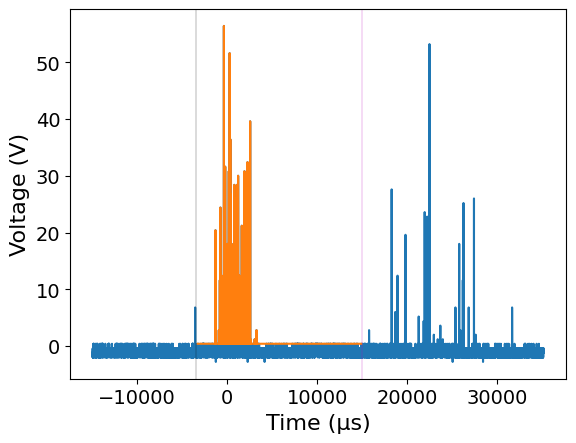

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in d

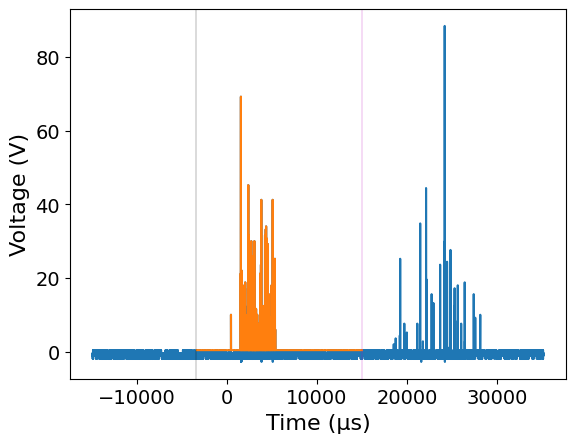

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in d

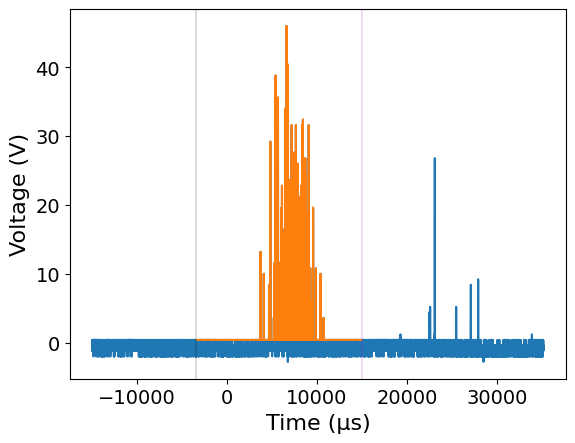

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Event 3019, area = 2395.8 mV·ns


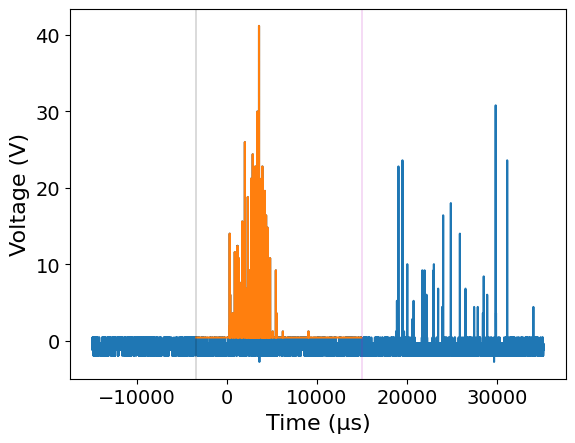

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in d

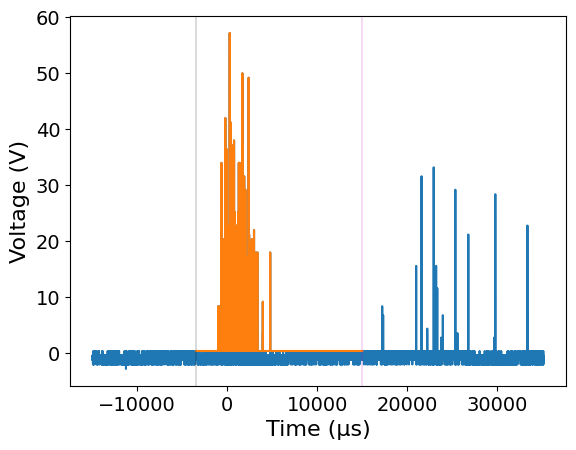

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in d

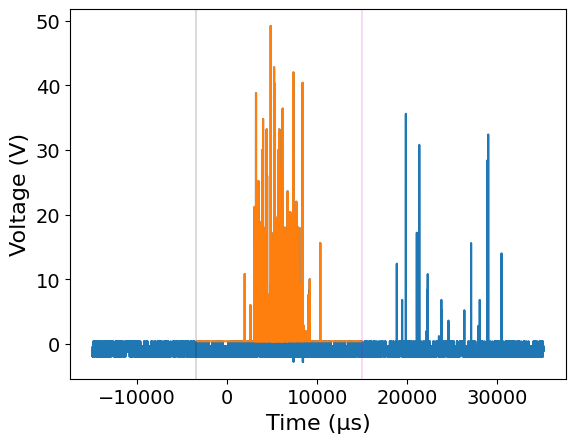

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in d

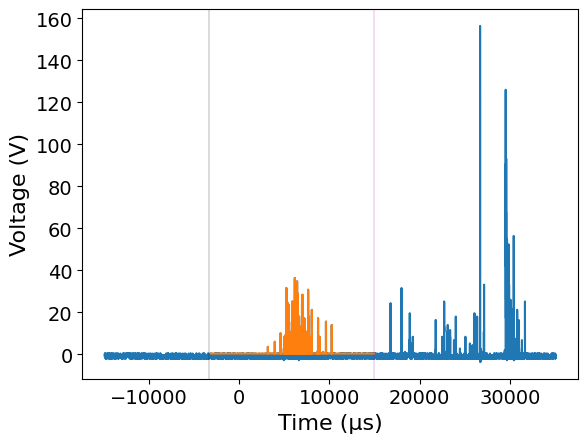

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in d

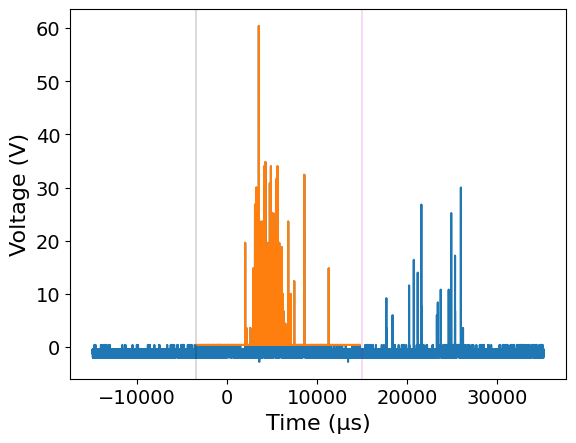

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in d

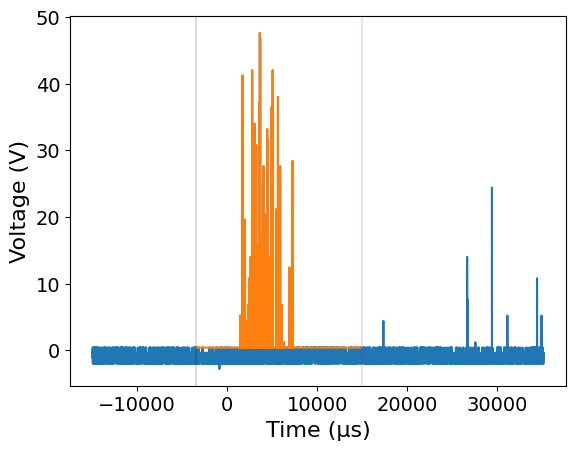

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Event 8448, area = 9451.6 mV·ns


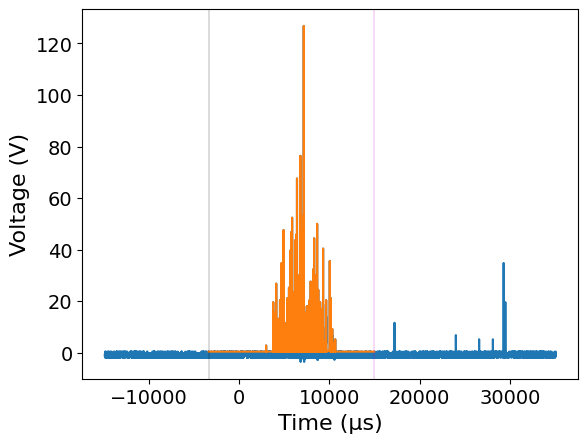

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Event 8488, area = 7023.4 mV·ns


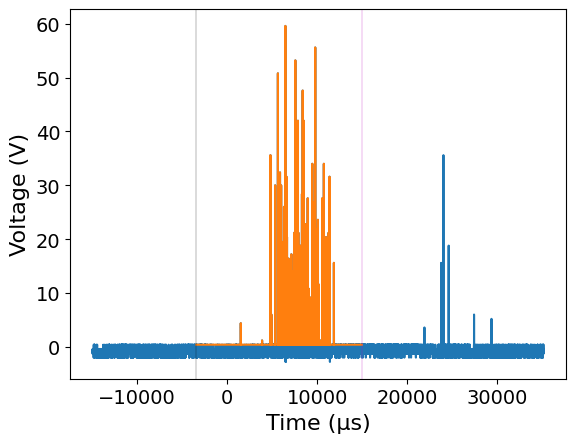

Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in drift
Detected alpha-like S2 signal above baseline, possible S1 in d

In [ ]:
idx_xray = []
area_xray = []
for i, file in enumerate(files05):
    t, V = load_waveform(file)
    t *= 1e9  # to ns
    V *= 1e3  # to mV
    ok, reason, (td, Vd) = cuts.classify_event_v2(V, t, t_s1, s2_start,
                                     bs_threshold=1,
                                     min_s2_sep = 3e3, min_s1_sep=2e3,
                                      flag_plot=False)
    if ok:
        # print(f'Event {i} candidate: {reason}')
        Vd = np.array(Vd)
        Vd_bs = Vd[Vd > 3e-4]
        area = np.sum(Vd_bs) * 0.2
        area_xray.append(area)  # mV·μs
        if area > 1200 and area < 20000:
            idx_xray.append(i)
            print(f'Event {i}, area = {area:.1f} mV·ns')
            td_bs = td[Vd > 3e-4]
            plt.plot(t, V)
            plt.plot(td_bs, Vd_bs)
            plt.gca().set(xlabel='Time (μs)', ylabel='Voltage (V)')
            plt.axvline(t_s1 ,color='k', lw=0.2)
            plt.axvline(s2_start, color='m', lw=0.2)
        plt.show()

In [323]:
len(area_xray_cut)

15

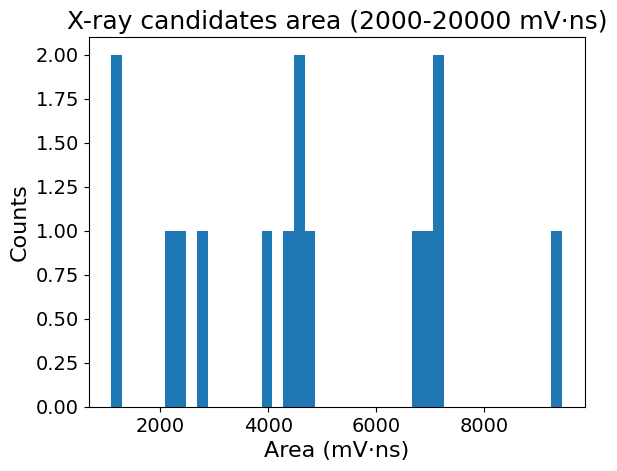

In [322]:
area_xray_cut = np.array(area_xray)
area_xray_cut = area_xray_cut[(area_xray_cut > 1000) & (area_xray_cut < 30000)]
n, bins, _ = plt.hist(area_xray_cut, bins=42,);
plt.gca().set(xlabel='Area (mV·ns)', ylabel='Counts', title='X-ray candidates area (2000-20000 mV·ns)');
# plt.xscale('log')   

In [328]:
nem = 8.4*10000/100/2

In [ ]:
mfp = 1 # cm for x-rays, at 2 bar Xe

In [324]:
np.mean(area_xray_cut), np.std(area_xray_cut)

(np.float64(4627.662999805808), np.float64(2393.46684586164))